In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [183]:
import catboost as cb
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb

In [3]:
train_df = pd.read_excel('../input/Final_Train.xlsx')
test_df = pd.read_excel('../input/Final_Test.xlsx')
sub_df = pd.read_excel('../input/Sample_submission.xlsx')

In [143]:
def show_all(df, nrow=None, ncol=None):
    with pd.option_context('display.max_rows', nrow, 'display.max_columns', ncol):
        display(df)

In [4]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100
1,"BAMS, MD - Ayurveda Medicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350
2,"MBBS, MS - Otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300
3,"BSc - Zoology, BAMS",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250
4,BAMS,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250


In [5]:
train_df.shape

(5961, 7)

In [6]:
train_df.isnull().sum()

Qualification            0
Experience               0
Rating                3302
Place                   25
Profile                  0
Miscellaneous_Info    2620
Fees                     0
dtype: int64

In [7]:
test_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info
0,MBBS,35 years experience,NaN,"Ghatkopar East, Mumbai",General Medicine,NaN
1,"MBBS, Diploma in Otorhinolaryngology (DLO)",31 years experience,NaN,"West Marredpally, Hyderabad",ENT Specialist,NaN
2,"MBBS, DDVL",40 years experience,70%,"KK Nagar, Chennai",Dermatologists,"70% 4 Feedback KK Nagar, Chennai"
3,BAMS,0 years experience,NaN,"New Ashok Nagar, Delhi",Ayurveda,NaN
4,"BDS, MDS - Conservative Dentistry & Endodontics",16 years experience,100%,"Kanakpura Road, Bangalore",Dentist,General Dentistry Conservative Dentistry Cosme...


In [8]:
test_df.isnull().sum()

Qualification            0
Experience               0
Rating                1090
Place                    6
Profile                  0
Miscellaneous_Info     834
dtype: int64

In [9]:
train_df['Experience'] = train_df['Experience'].str[0:-17].astype(int)

In [10]:
test_df['Experience'] = test_df['Experience'].str[0:-17].astype(int)

In [17]:
train_df['Rating'] = train_df['Rating'].str[0:-1].astype(float)
test_df['Rating'] = test_df['Rating'].str[0:-1].astype(float)

In [11]:
train_df['Place'].fillna('none, none', inplace=True)
test_df['Place'].fillna('none, none', inplace=True)

In [12]:
train_df['Area'] = train_df['Place'].str.rsplit(',', 1).str.get(0)
train_df['City'] = train_df['Place'].str.rsplit(',', 1).str.get(1)
test_df['Area'] = test_df['Place'].str.rsplit(',', 1).str.get(0)
test_df['City'] = test_df['Place'].str.split(',', 1).str.get(1)

In [13]:
train_df['City'] = train_df['City'].str.strip()
test_df['City'] = test_df['City'].str.strip()

In [18]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Area,City
0,"BHMS, MD - Homeopathy",24,100.0,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,Kakkanad,Ernakulam
1,"BAMS, MD - Ayurveda Medicine",12,98.0,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,Whitefield,Bangalore
2,"MBBS, MS - Otorhinolaryngology",9,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,Mathikere - BEL,Bangalore
3,"BSc - Zoology, BAMS",12,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,Bannerghatta Road,Bangalore
4,BAMS,20,100.0,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,Keelkattalai,Chennai


In [19]:
train_df['City'].unique()

array(['Ernakulam', 'Bangalore', 'Chennai', 'Delhi', 'Hyderabad',
       'Coimbatore', 'Mumbai', 'Thiruvananthapuram', 'none', nan],
      dtype=object)

In [20]:
test_df['City'].unique()

array(['Mumbai', 'Hyderabad', 'Chennai', 'Delhi', 'Bangalore',
       'Coimbatore', 'Thiruvananthapuram', 'Ernakulam', 'none'],
      dtype=object)

In [21]:
train_df[train_df['City'].isnull()]

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Area,City
3980,BDS,23,NaN,e,Dentist,NaN,250,e,NaN


In [22]:
train_df.loc[train_df['City'].isnull(), 'Area'] = 'none'
train_df['City'] = train_df['City'].fillna('none')

In [23]:
train_df['City'].unique()

array(['Ernakulam', 'Bangalore', 'Chennai', 'Delhi', 'Hyderabad',
       'Coimbatore', 'Mumbai', 'Thiruvananthapuram', 'none'], dtype=object)

In [24]:
train_df['Area'].nunique()

867

In [25]:
train_df['Profile'].unique()

array(['Homeopath', 'Ayurveda', 'ENT Specialist', 'Dentist',
       'General Medicine', 'Dermatologists'], dtype=object)

In [26]:
test_df['Profile'].unique()

array(['General Medicine', 'ENT Specialist', 'Dermatologists', 'Ayurveda',
       'Dentist', 'Homeopath'], dtype=object)

In [124]:
train_df['Has_M_Info'] = (~train_df['Miscellaneous_Info'].isnull())
test_df['Has_M_Info'] = (~test_df['Miscellaneous_Info'].isnull())
train_df['Has_M_Info'] = train_df['Has_M_Info'].astype(int)
test_df['Has_M_Info'] = test_df['Has_M_Info'].astype(int)

In [126]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Area,City,Has_M_Info
0,"BHMS, MD - Homeopathy",24,100.0,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,Kakkanad,Ernakulam,1
1,"BAMS, MD - Ayurveda Medicine",12,98.0,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,Whitefield,Bangalore,1
2,"MBBS, MS - Otorhinolaryngology",9,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,Mathikere - BEL,Bangalore,0
3,"BSc - Zoology, BAMS",12,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,Bannerghatta Road,Bangalore,1
4,BAMS,20,100.0,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,Keelkattalai,Chennai,1


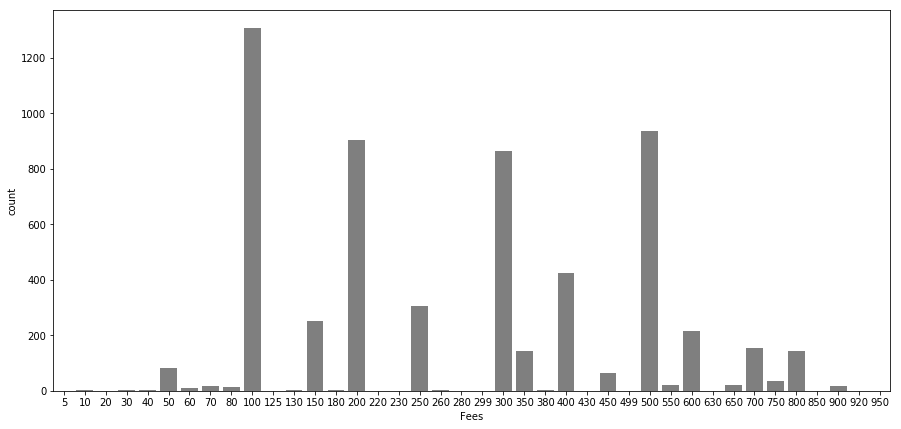

In [113]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.countplot(train_df['Fees'].sort_values(), ax=ax, color='k', alpha=0.5)
plt.show()

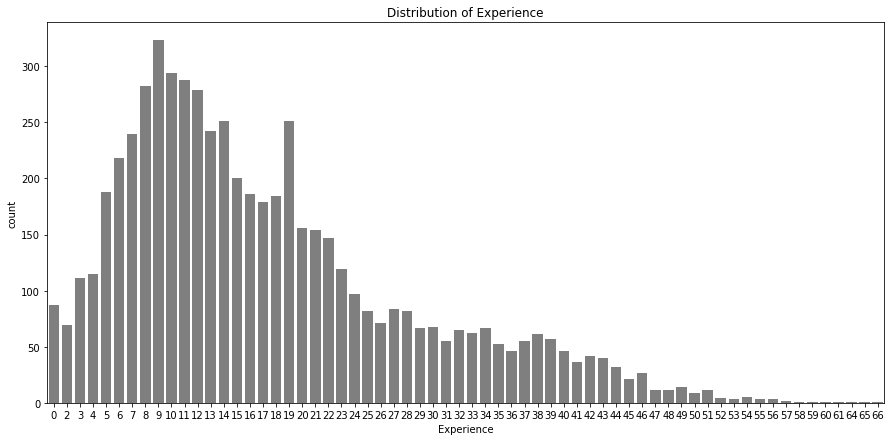

In [58]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(train_df['Experience'], ax=ax, color='k', alpha=0.5)
ax.set(title='Distribution of Experience')
plt.show()

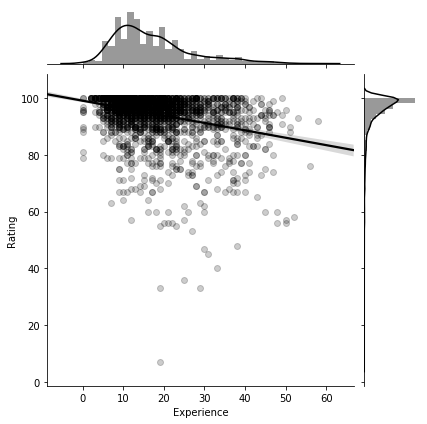

In [31]:
sns.jointplot(train_df['Experience'], train_df['Rating'], color='k', kind="reg", fit_reg=True, joint_kws={'scatter_kws':{"alpha": 0.2}})
plt.show()

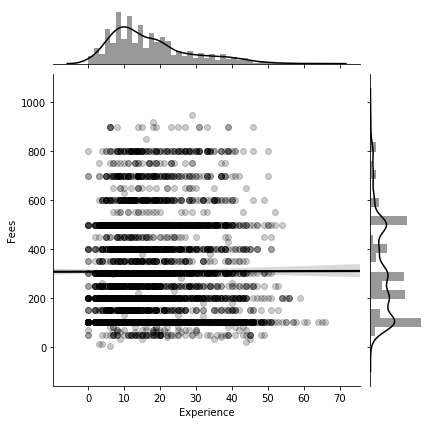

In [32]:
sns.jointplot(train_df['Experience'], train_df['Fees'], color='k', kind="reg", fit_reg=True,joint_kws={'scatter_kws':{"alpha": 0.2}})
plt.show()

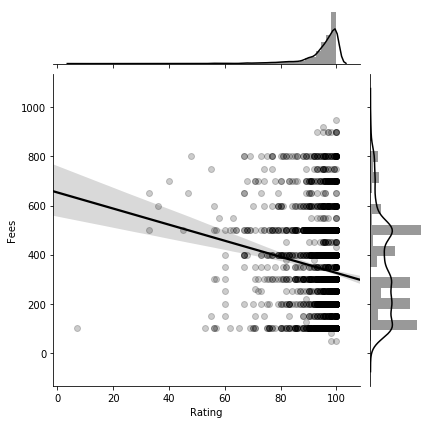

In [33]:
sns.jointplot(train_df['Rating'], train_df['Fees'], color='k', kind="reg", fit_reg=True,joint_kws={'scatter_kws':{"alpha": 0.2}})
plt.show()

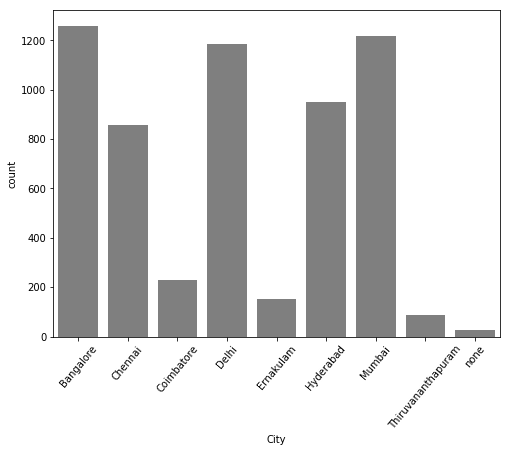

In [60]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(train_df['City'].sort_values(), ax=ax, color='k', alpha=0.5)
plt.xticks(rotation=50)
plt.show()

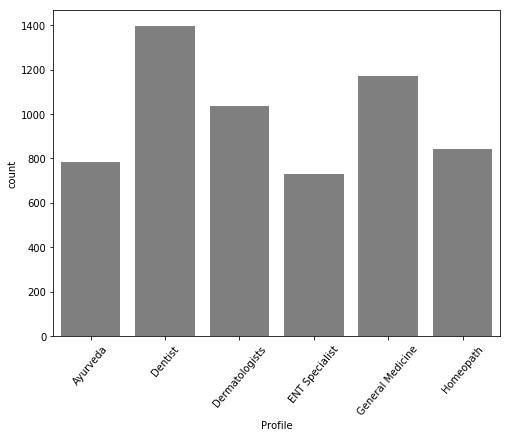

In [61]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(train_df['Profile'].sort_values(), ax=ax, color='k', alpha=0.5)
plt.xticks(rotation=50)
plt.show()

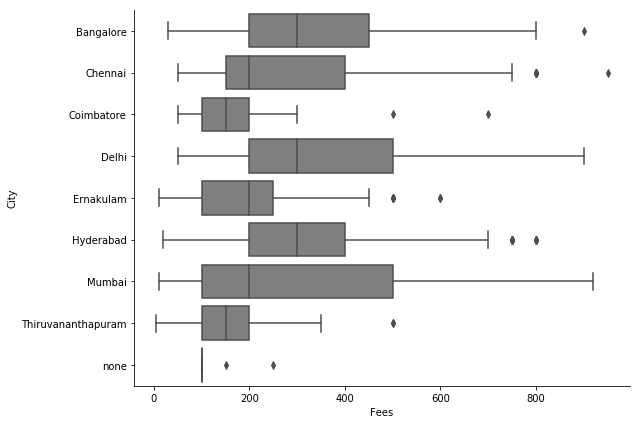

In [55]:
sns.catplot(x='Fees', y='City', data=train_df.sort_values("City"), kind='box', height=6, aspect= 1.5, color='gray')
plt.show()

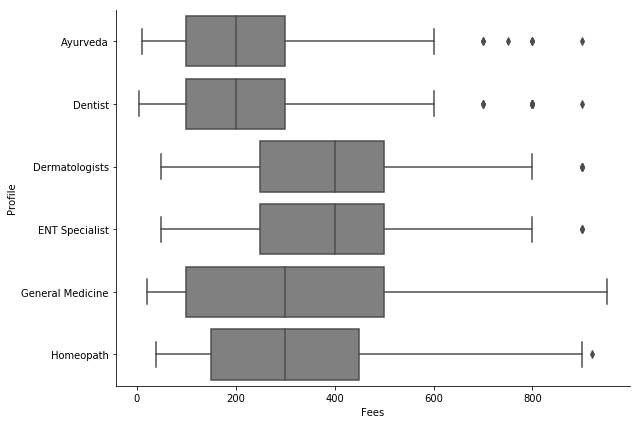

In [59]:
sns.catplot(x='Fees', y='Profile', data=train_df.sort_values("Profile"), kind='box', height=6, aspect= 1.5, color='gray')
plt.show()

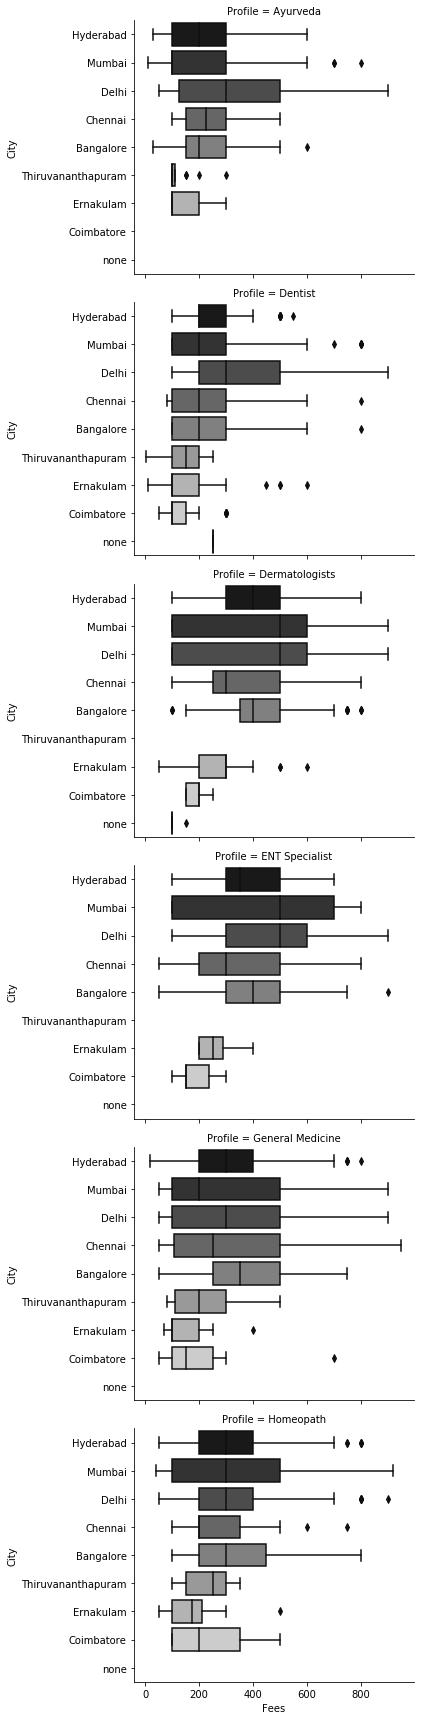

In [103]:
sns.catplot(x='Fees', y='City', row='Profile', data=train_df.sort_values("Profile"), kind='box', height=4, aspect= 1.5, palette="gray")
plt.show()

/home/nishant/venvs_dir/DS/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/nishant/venvs_dir/DS/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


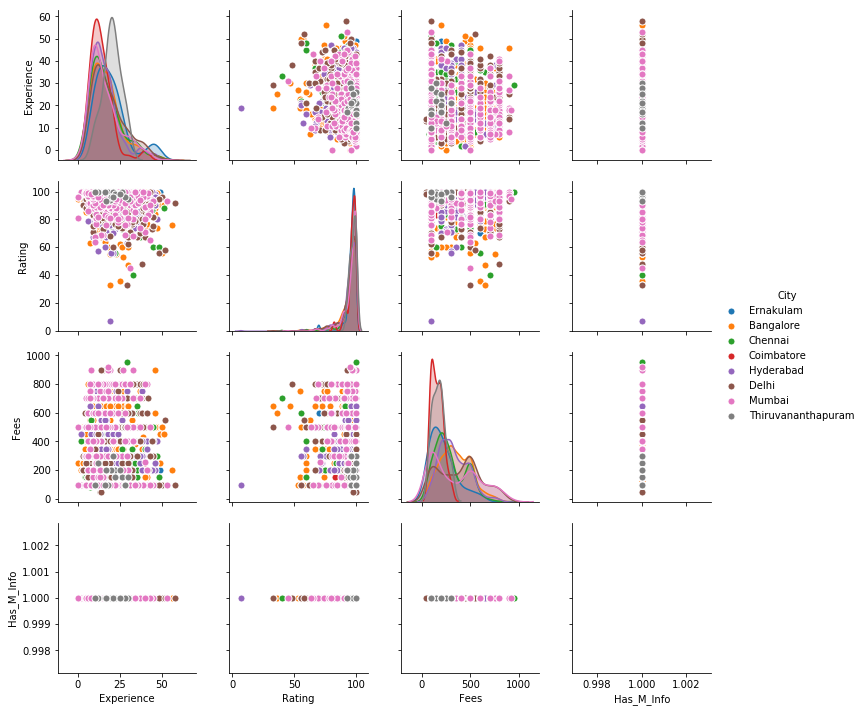

In [101]:
sns.pairplot(train_df.dropna().drop(['Qualification', 'Place', 'Area', 'Miscellaneous_Info'], axis=1), kind="scatter", hue="City", plot_kws=dict(s=50, edgecolor="white", linewidth=1))
plt.show()


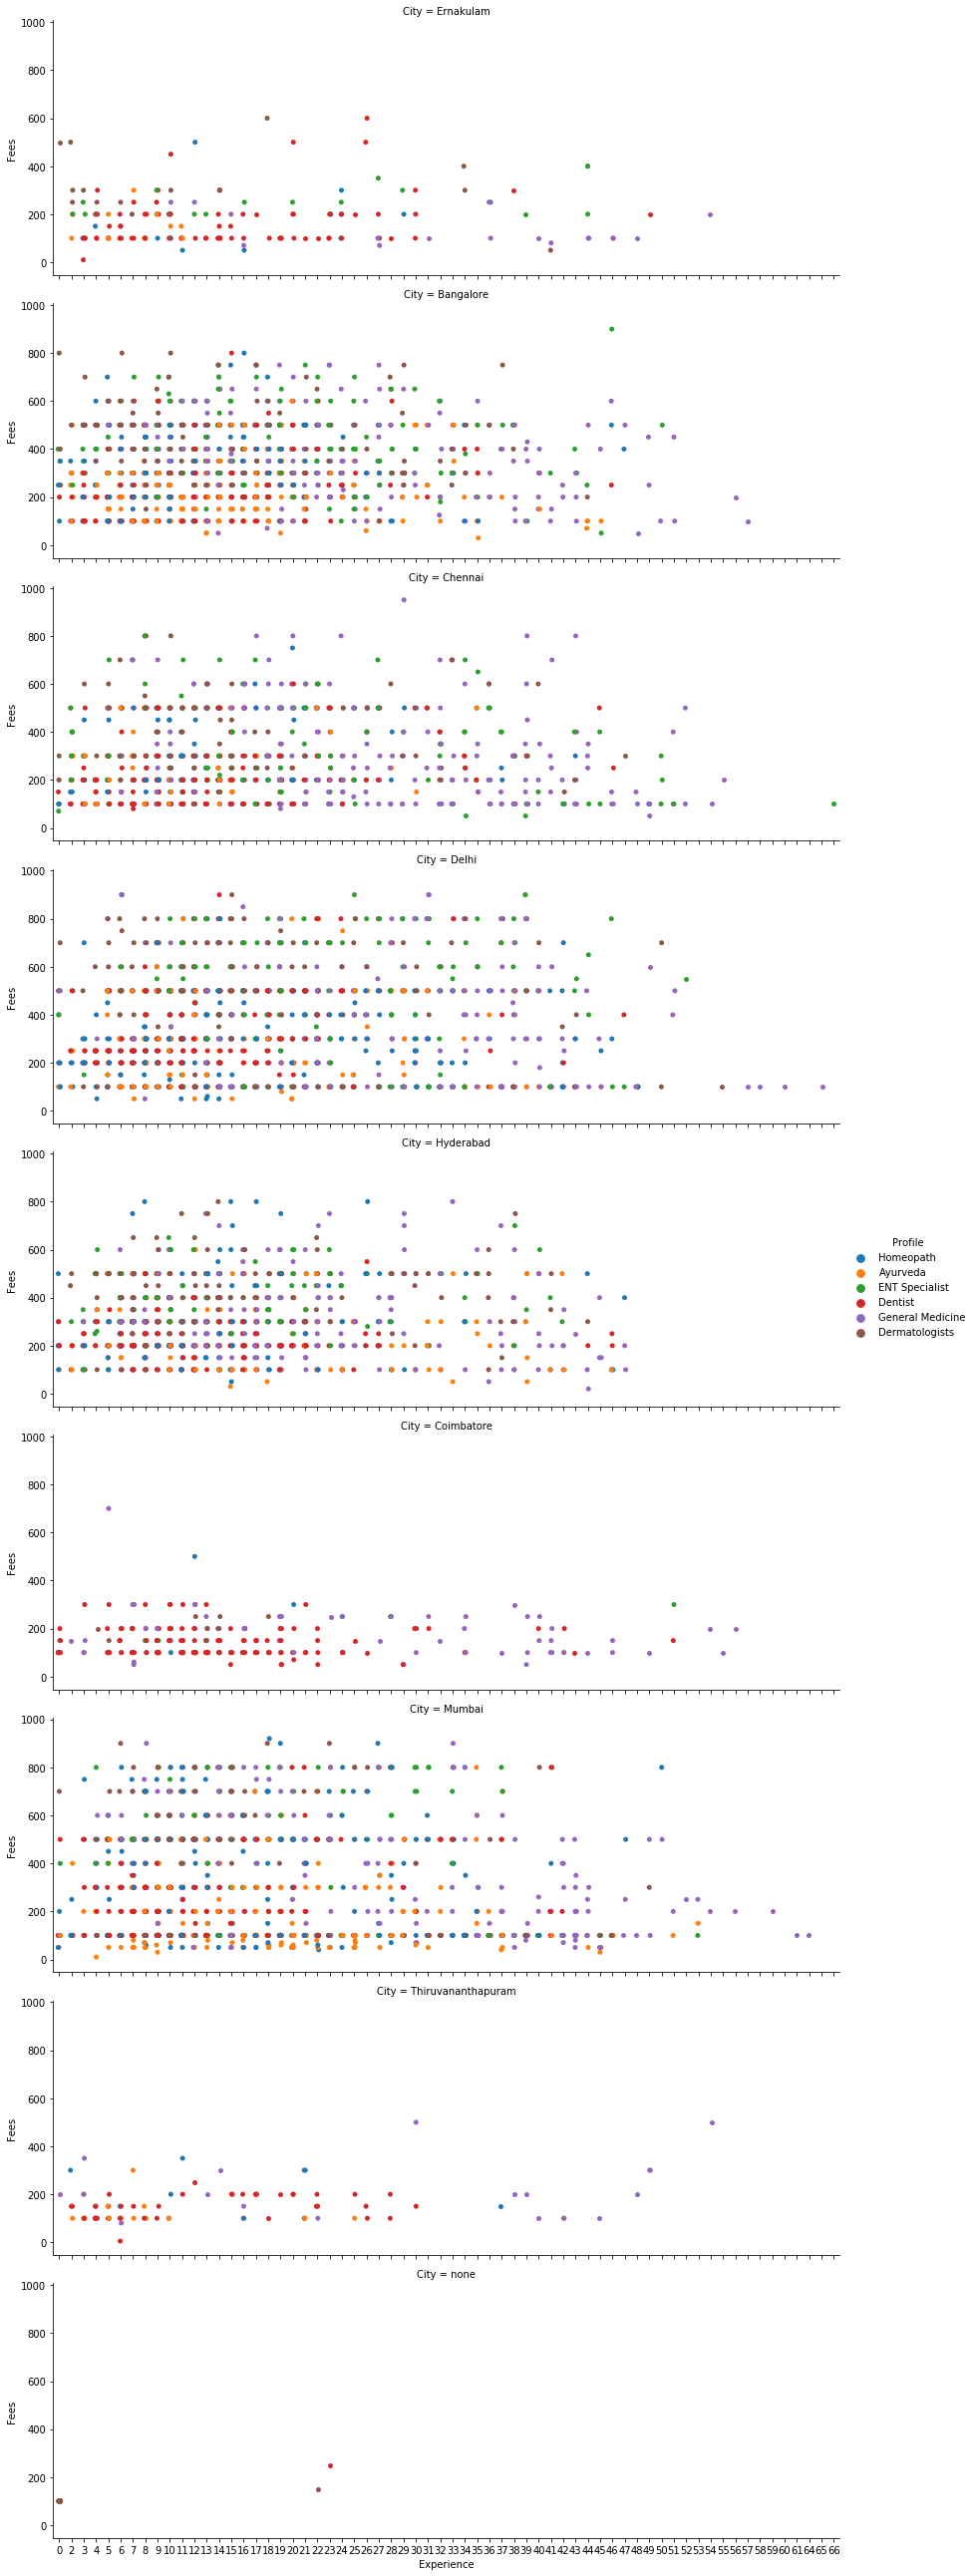

In [108]:
sns.catplot(x='Experience', y='Fees', row='City', hue='Profile', data=train_df, height=4, aspect= 3)
plt.show()

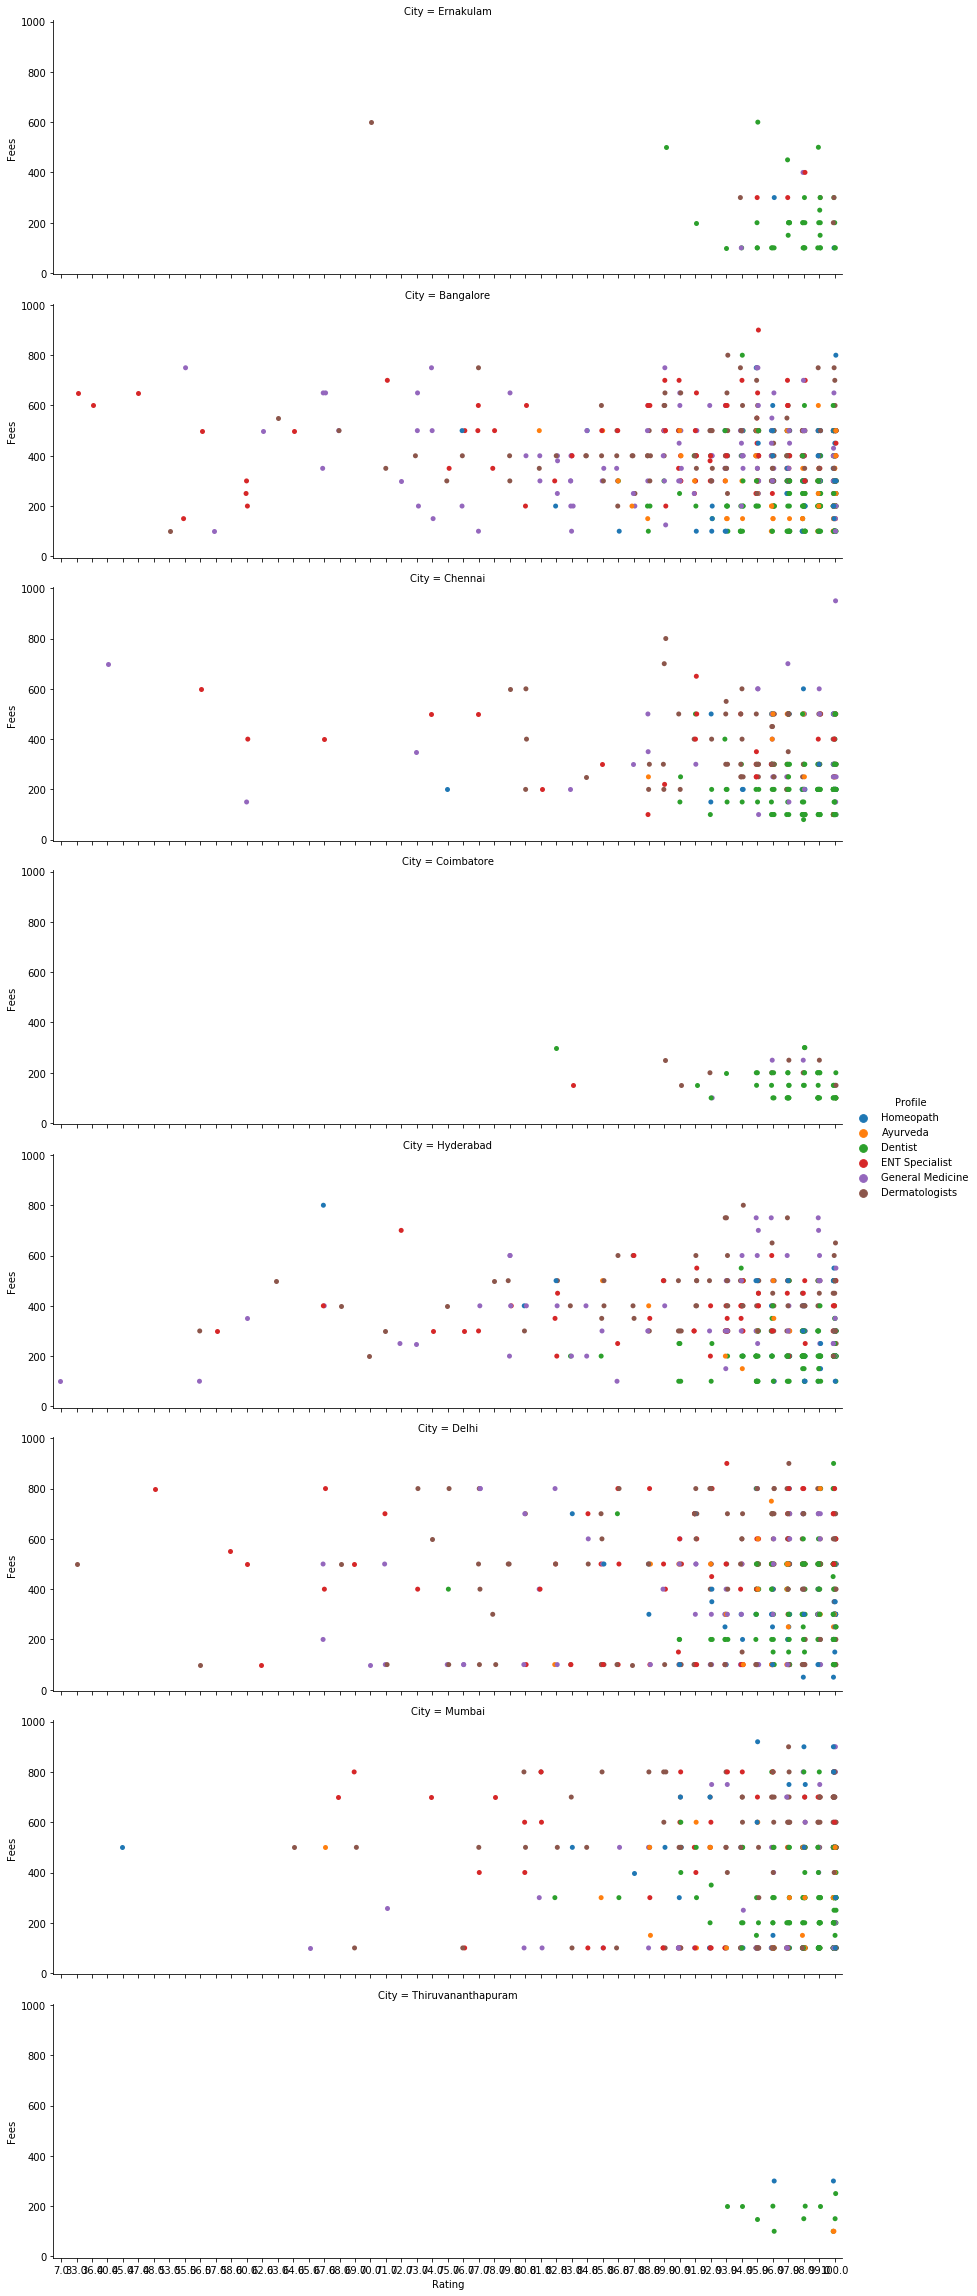

In [133]:
sns.catplot(x='Rating', y='Fees', row='City', hue='Profile', data=train_df.dropna(), height=4, aspect= 3)
plt.show()

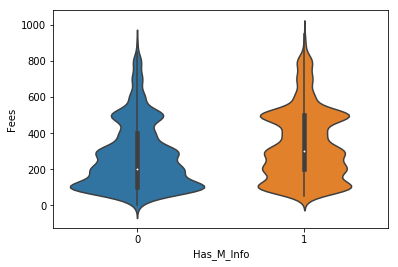

In [134]:
sns.violinplot(x = 'Has_M_Info', y = 'Fees', data=train_df)
plt.show()

In [137]:
quals = pd.DataFrame(item for item in train_df['Qualification'].str.split(', '))

In [140]:
quals.head()

,0,1,2,3,4,5,6,7,8,9
0,BHMS,MD - Homeopathy,None,None,None,None,None,None,None,None
1,BAMS,MD - Ayurveda Medicine,None,None,None,None,None,None,None,None
2,MBBS,MS - Otorhinolaryngology,None,None,None,None,None,None,None,None
3,BSc - Zoology,BAMS,None,None,None,None,None,None,None,None
4,BAMS,None,None,None,None,None,None,None,None,None


In [139]:
quals.isnull().sum()

0       0
1    1962
2    4598
3    5592
4    5842
5    5926
6    5949
7    5956
8    5958
9    5960
dtype: int64

In [154]:
for i in range(10):
    print(quals[i].nunique())

151
425
405
209
95
32
12
5
3
1


In [161]:
quals[0].value_counts()

MBBS                                                        2448
BDS                                                         1208
BAMS                                                         711
BHMS                                                         706
MD - Dermatology                                              84
MS - ENT                                                      71
MD - Dermatology                                              62
MD - Homeopathy                                               56
MD - Ayurveda Medicine                                        38
DHMS (Diploma in Homeopathic Medicine and Surgery)            36
MD - General Medicine                                         26
MDS - Oral & Maxillofacial Surgery                            26
MDS - Conservative Dentistry & Endodontics                    25
MS - Otorhinolaryngology                                      25
Get inspired by remarkable stories of people like you         24
DDVL                     

In [170]:
vecz = TfidfVectorizer(analyzer='word')

In [174]:
vecz.fit(train_df['Qualification'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [175]:
qual_train = vecz.transform(train_df['Qualification'])

In [176]:
qual_train

<5961x699 sparse matrix of type '<class 'numpy.float64'>'
	with 22663 stored elements in Compressed Sparse Row format>

In [177]:
qual_test = vecz.transform(test_df['Qualification'])

In [178]:
qual_test

<1987x699 sparse matrix of type '<class 'numpy.float64'>'
	with 7799 stored elements in Compressed Sparse Row format>

In [185]:
svd = TruncatedSVD(n_components=20)
svd.fit(qual_train)
print(svd.explained_variance_ratio_.sum())
print(svd.explained_variance_ratio_)

0.7305595187142095
[0.0651461  0.0932571  0.08841786 0.09215534 0.06995137 0.04716524
 0.04335796 0.0386357  0.02726828 0.02072665 0.01942378 0.01691497
 0.01640643 0.01555551 0.01513252 0.01454679 0.01366493 0.01325784
 0.01008382 0.00949134]


In [186]:
qual_train = svd.transform(qual_train)
qual_train = pd.DataFrame(qual_train, columns=['svd_{}'.format(i) for i in range(20)])
train_df = pd.concat((train_df, qual_train), axis=1)
qual_test = svd.transform(qual_test)
qual_test = pd.DataFrame(qual_test, columns=['svd_{}'.format(i) for i in range(20)])
test_df = pd.concat((test_df, qual_test), axis=1)

In [188]:
show_all(train_df.head())

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Area,City,Has_M_Info,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19
0,"BHMS, MD - Homeopathy",24,100.0,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,Kakkanad,Ernakulam,1,0.204698,-0.004905,0.617614,-0.094015,-0.160937,0.038923,-0.176068,-0.056247,-0.029596,0.469659,0.178302,0.227160,-0.325482,0.006805,-0.233823,0.164206,0.075249,-0.023664,0.000856,-0.029655
1,"BAMS, MD - Ayurveda Medicine",12,98.0,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,Whitefield,Bangalore,1,0.268381,-0.001537,0.122677,0.555758,-0.217448,0.304366,-0.322422,-0.039006,-0.031482,0.040155,0.082559,0.054605,0.101383,-0.115282,0.429621,0.089232,0.199147,-0.232469,-0.001321,-0.092504
2,"MBBS, MS - Otorhinolaryngology",9,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,Mathikere - BEL,Bangalore,0,0.421921,-0.009890,-0.076033,-0.047997,0.483719,-0.076854,-0.143327,0.128528,-0.047774,0.046826,-0.042409,0.289287,-0.147427,-0.029980,0.268566,-0.187960,-0.286506,0.069732,-0.126988,0.000980
3,"BSc - Zoology, BAMS",12,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,Bannerghatta Road,Bangalore,1,0.019226,0.000641,0.042800,0.252416,0.020670,-0.017922,0.022171,0.001428,0.001324,-0.001619,-0.003270,-0.002047,-0.004654,0.004884,-0.017885,-0.002697,-0.006755,0.007463,-0.002412,0.005209
4,BAMS,20,100.0,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,Keelkattalai,Chennai,1,0.073281,0.000587,0.162586,0.970117,0.079316,-0.069387,0.087409,0.000966,0.004395,-0.007642,-0.014115,-0.001964,-0.017864,0.022023,-0.063619,-0.018406,-0.026628,0.031917,0.002727,0.016303


In [191]:
features = [col for col in test_df.columns if col not in ['Qualification', 'Place', 'Miscellaneous_Info', 'Area']]

In [192]:
features

['Experience',
 'Rating',
 'Profile',
 'City',
 'Has_M_Info',
 'svd_0',
 'svd_1',
 'svd_2',
 'svd_3',
 'svd_4',
 'svd_5',
 'svd_6',
 'svd_7',
 'svd_8',
 'svd_9',
 'svd_10',
 'svd_11',
 'svd_12',
 'svd_13',
 'svd_14',
 'svd_15',
 'svd_16',
 'svd_17',
 'svd_18',
 'svd_19']

In [193]:
cat_inds = [2,3,4]

In [214]:
[features[i] for i in cat_inds]

['Profile', 'City', 'Has_M_Info']

In [221]:
def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [222]:
def run_cv_model(train, target, model_fn, params={}, n_repeats=1, n_splits=5, test=None, eval_fn=None, label='model', cv_verbose = False, model_verbose=False):
    kf = RepeatedKFold(n_splits=n_splits, random_state=42, n_repeats = n_repeats)
    fold_splits = kf.split(train, target)
    cv_scores = []
    rmsle_scores = []
    pred_full_test = np.zeros((test.shape[0], n_splits*n_repeats))
    pred_train = np.zeros((train.shape[0], n_splits*n_repeats))
    feature_importance_df = pd.DataFrame()
    i = 1
    for dev_index, val_index in fold_splits:
        if cv_verbose:
            print('Started ' + label + ' fold ' + str(i) + '/'+str(n_splits*n_repeats))
        if isinstance(train, pd.DataFrame):
            dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        else:
            dev_X, val_X = train[dev_index], train[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y, importances, rmsle = model_fn(dev_X, dev_y, val_X, val_y, test, params2, model_verbose)
        pred_full_test[:, i-1] = pred_test_y.flatten()
        pred_train[val_index] = pred_val_y
        if eval_fn is not None:
            cv_score = eval_fn(val_y, pred_val_y)
            cv_scores.append(cv_score)
            rmsle_scores.append(rmsle)
            if cv_verbose:
                print(label + ' cv score {}: RMSE {}, RMSLE {}'.format(i, cv_score, rmsle))
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = train.columns.values
        fold_importance_df['importance'] = importances
        fold_importance_df['fold'] = i
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)        
        i += 1
    
    if cv_verbose:
        print("\n\n CV - Report\n")
        print('{} cv RMSE scores : {}'.format(label, cv_scores))
        print('{} cv mean RMSE score : {}'.format(label, np.mean(cv_scores)))
        print('{} cv std RMSE score : {}'.format(label, np.std(cv_scores)))
        print('{} cv RMSLE scores : {}'.format(label, rmsle_scores))
        print('{} cv mean RMSLE score : {}'.format(label, np.mean(rmsle_scores)))
        print('{} cv std RMSLE score : {}'.format(label, np.std(rmsle_scores)))
    results = {'label': label,
               'train': pred_train, 'test': pred_full_test,
                'cv': cv_scores, 'rmsle': rmsle_scores,
               'importance': feature_importance_df}
    return results

In [269]:
def runCatBoostReg(train_X, train_y, test_X, test_y, test_X2, params, model_verbose):
    if model_verbose:
        print('Prep Catboost Regressor')
    cat_ind = params.pop('cat_features')
    val_pool = cb.Pool(test_X.values, test_y.values, cat_features=cat_ind)
    model = cb.CatBoostRegressor()
    model.set_params(** params)
    if model_verbose:
        print('Train Catboost Regressor')
    model.fit(X=train_X, y=train_y, eval_set=val_pool, cat_features=cat_ind, use_best_model=True)
    
    if model_verbose:
        print('Predict validation set')
    pred_test_y = model.predict(test_X)
    rmsle = np.sqrt(mean_squared_log_error(test_y, pred_test_y))
    if model_verbose:
        print('Predict actual test set')
    if test_X2 is not None:
        pred_test_y2 = model.predict(test_X2)
        pred_test_y2 = pred_test_y2.reshape(-1, 1)
    else:
        pred_test_y2 = 0
    pred_test_y = pred_test_y.reshape(-1, 1)
    return pred_test_y, pred_test_y2, model.feature_importances_, rmsle

In [270]:
catboost_params = {'iterations': 10000,
                   'learning_rate': 0.06,
                   'depth': 8,
                   'loss_function': 'RMSE',
                   'eval_metric': 'RMSE',
                   'random_seed': 2018,
                   'l2_leaf_reg': 3,
                   'early_stopping_rounds': 400,
                   'use_best_model': True,
                   'verbose': 100,
                   'cat_features': cat_inds}

results = run_cv_model(train_df[features], train_df['Fees'], runCatBoostReg, catboost_params, n_repeats=1, n_splits=5, test=test_df[features], eval_fn=rmse, label='CatBoost', cv_verbose=True, model_verbose=True)

Started CatBoost fold 1/5
Prep Catboost Regressor
Train Catboost Regressor
0:	learn: 346.8537505	test: 344.0301698	best: 344.0301698 (0)	total: 29.1ms	remaining: 4m 51s
100:	learn: 163.2980774	test: 164.0183700	best: 163.9714226 (96)	total: 2.23s	remaining: 3m 39s
200:	learn: 155.9754752	test: 164.4572617	best: 163.8269465 (140)	total: 4.91s	remaining: 3m 59s
300:	learn: 149.8435663	test: 165.6367687	best: 163.8269465 (140)	total: 7.63s	remaining: 4m 5s
400:	learn: 145.6266987	test: 166.8304764	best: 163.8269465 (140)	total: 10.4s	remaining: 4m 8s
500:	learn: 141.7970689	test: 167.7008080	best: 163.8269465 (140)	total: 13.1s	remaining: 4m 8s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 163.8269465
bestIteration = 140

Shrink model to first 141 iterations.
Predict validation set
Predict actual test set
CatBoost cv score 1: RMSE 163.82694645020638, RMSLE 0.606013109642988
Started CatBoost fold 2/5
Prep Catboost Regressor
Train Catboost Regressor
0:	learn: 346.457794

In [271]:
imports = results['importance'].groupby('feature')['feature', 'importance'].mean().reset_index()
show_all(imports.sort_values('importance', ascending=False).reset_index(drop=True))

,feature,importance
0,City,13.420340
1,Experience,9.569064
2,Profile,8.610371
3,Has_M_Info,8.002833
4,svd_0,7.425669
5,svd_1,4.287892
6,Rating,3.760380
7,svd_10,3.404660
8,svd_3,3.328850
9,svd_5,3.165135


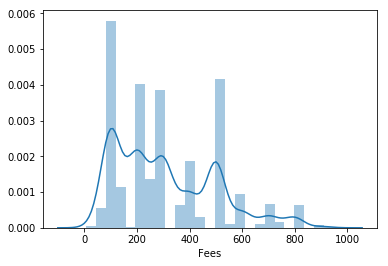

In [280]:
# Acctual target
sns.distplot(train_df['Fees'])
plt.show()

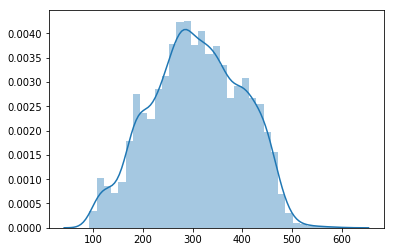

In [281]:
# predicted target
sns.distplot(results['train'][:, 0])
plt.show()

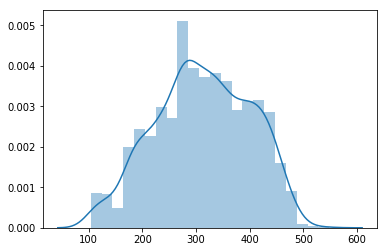

In [283]:
# Test target
sns.distplot(np.mean(results['test'], axis=1))
plt.show()

In [287]:
sub_df['Fees'] = np.mean(results['test'], axis=1)

In [288]:
sub_df.head()

,Fees
0,229.722544
1,273.851517
2,347.222979
3,212.698861
4,283.637994


In [291]:
sub_df.to_excel('../submissions/sub.xlsx', index=False)

In [292]:
sub_df.to_csv('../submissions/sub.csv', index=False)

#### Refferences
http://seaborn.pydata.org/introduction.html#figure-level-and-axes-level-functions

https://www.kaggle.com/general/9933